<a href="https://colab.research.google.com/github/adnan119/Pytorch-Projects/blob/main/ResNet/train_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%cd drive/My Drive/Pytorch-Projects/ResNet

/content/drive/My Drive/Pytorch-Projects/ResNet


In [ ]:
# from copy_resnet import test_1
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
import numpy as np

from resnet import ResNet101

# **1.Loading Dataset**

In [ ]:
#defining transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    #  transforms.CenterCrop(100),
    #  transforms.RandomPerspective(p=0.5),
     transforms.RandomHorizontalFlip(p=0.5)])

test_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))]
)

In [ ]:
#defining dataset and dataloaders

batch_size = 512

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)


trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


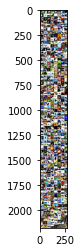

 deer  ship   dog horse


In [ ]:
# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))


# **2. Defining the model**

In [ ]:
resume = False

In [ ]:
model = ResNet101()
if resume:
  checkpoint = torch.load('r101_cifar10.pt')
  model.load_state_dict(checkpoint)
model.cuda()
params = list(model.parameters())
print(len(params))
print(params[17].size())

351
torch.Size([64, 256, 1, 1])


In [ ]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): block(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (identity_downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(256

# **3. Loss function and optimizer**

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)
lrsheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

# **4. Train the network**

In [ ]:
epochs = 70
test_loss_min = np.Inf
test_loss = 0
total = 0
correct = 0

for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    print(lrsheduler.get_lr())
    model.train()
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        if i % 2000 == 0:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

    model.eval()
    for i, data in enumerate(testloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to('cuda'), labels.to('cuda')

        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)

        test_loss += loss.item()*inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    lrsheduler.step()
    test_loss = test_loss/len(testloader.dataset)
    _correct = (correct*100)/total


    print('Epoch: {} \tTest Loss: {:.6f} \tAccuracy: {:.6f}'.format(
        epoch, test_loss, _correct))
    
    if test_loss <= test_loss_min:
        print('test loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        test_loss_min,
        test_loss))
        
    #to save the check-points
        
        torch.save(model.state_dict(), 'r101_cifar10.pt')
        test_loss_min = test_loss
    


print('Finished Training')

[0.1]


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[1,     1] loss: 0.004
Epoch: 0 	Test Loss: 3.566844 	Accuracy: 12.380000
test loss decreased (inf --> 3.566844).  Saving model ...
[0.1]
[2,     1] loss: 0.001
Epoch: 1 	Test Loss: 1.836268 	Accuracy: 22.650000
test loss decreased (3.566844 --> 1.836268).  Saving model ...
[0.1]
[3,     1] loss: 0.001
Epoch: 2 	Test Loss: 1.627756 	Accuracy: 28.213333
test loss decreased (1.836268 --> 1.627756).  Saving model ...
[0.1]
[4,     1] loss: 0.001
Epoch: 3 	Test Loss: 1.500936 	Accuracy: 32.167500
test loss decreased (1.627756 --> 1.500936).  Saving model ...
[0.1]
[5,     1] loss: 0.001
Epoch: 4 	Test Loss: 1.511731 	Accuracy: 35.298000
[0.1]
[6,     1] loss: 0.001
Epoch: 5 	Test Loss: 2.047717 	Accuracy: 33.343333
[0.1]
[7,     1] loss: 0.001
Epoch: 6 	Test Loss: 2.144908 	Accuracy: 32.234286
[0.1]
[8,     1] loss: 0.001
Epoch: 7 	Test Loss: 1.805937 	Accuracy: 32.546250
[0.1]
[9,     1] loss: 0.001
Epoch: 8 	Test Loss: 2.350163 	Accuracy: 33.024444
[0.1]
[10,     1] loss: 0.001
Epoch: 9 

# **5. Testing the network**